# Task 1

In [45]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# file_path = '/content/drive/.shortcut-targets-by-id/1vkknCL6OjwZzWbtKB-zBXYSXEFQyKkjV/stats m148/dat_train1.csv'
file_path = 'dat_train1.csv'

df = pd.read_csv(file_path)
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# define a duplicate as same user, same action, same time
duplicate_mask = df.duplicated(subset=['customer_id', 'event_name', 'event_timestamp'], keep='first')
num_duplicates = duplicate_mask.sum()
total_rows_before = len(df)
proportion_duplicates = num_duplicates / total_rows_before

# remove duplicates
df_clean = df[~duplicate_mask].copy()
total_rows_after = len(df_clean)

# fix action counter (journey_steps_until_end)
# sort by customer and time, then group by customer to re-assign the step numbers
df_clean = df_clean.sort_values(by=['customer_id', 'event_timestamp'])
df_clean['journey_steps_until_end'] = df_clean.groupby('customer_id').cumcount() + 1

# 1. Filter for successful orders only
# df_clean is the dataframe after removing duplicates in Task 2
df_orders = df_clean[df_clean['event_name'] == 'order_shipped'].copy()

# Ensure the timestamp is in datetime format
df_orders['event_timestamp'] = pd.to_datetime(df_orders['event_timestamp'])

# Cut off data so it starts in Feb 2021 (data providers mentioned the first little stretch is inaccurate)
df_orders = df_orders[df_orders['event_timestamp'] >= '2021-02-01'].copy()

12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


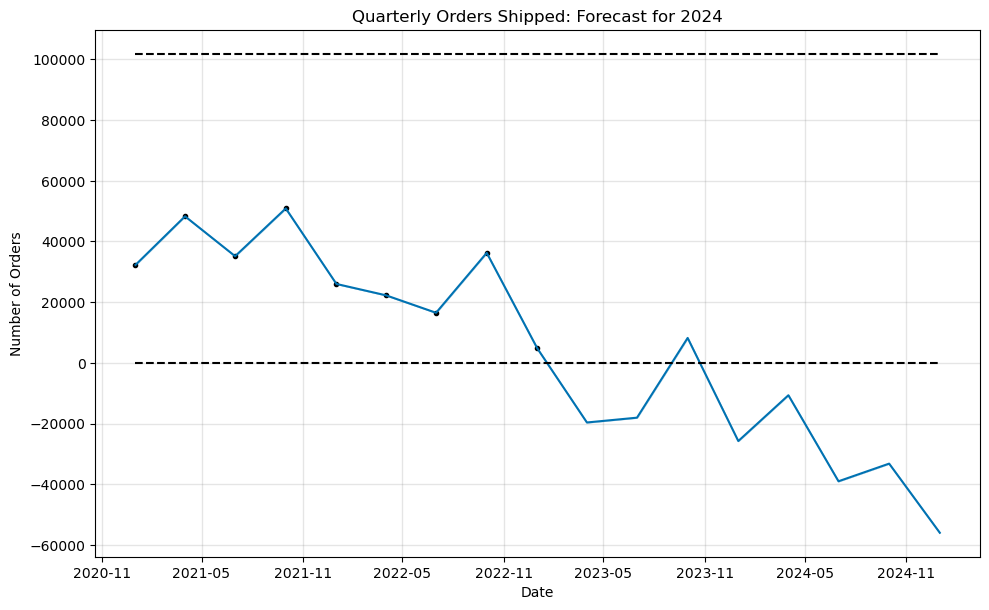

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

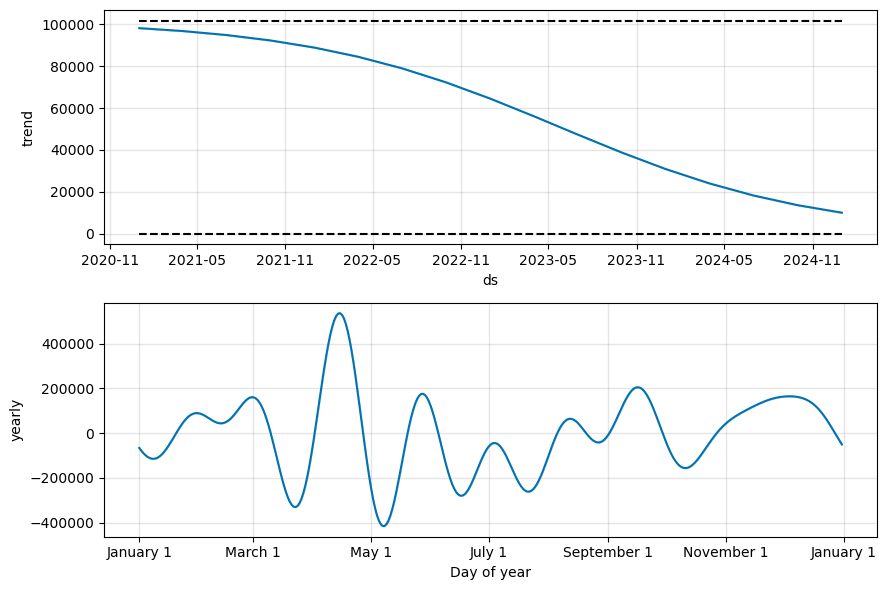

In [46]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to 0 to prevent negative predictions
quarterly_series['floor'] = 0
# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth to enforce the floor and cap
m = Prophet(growth='logistic')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = 0
future['cap'] = max_orders * 2

forecast = m.predict(future)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


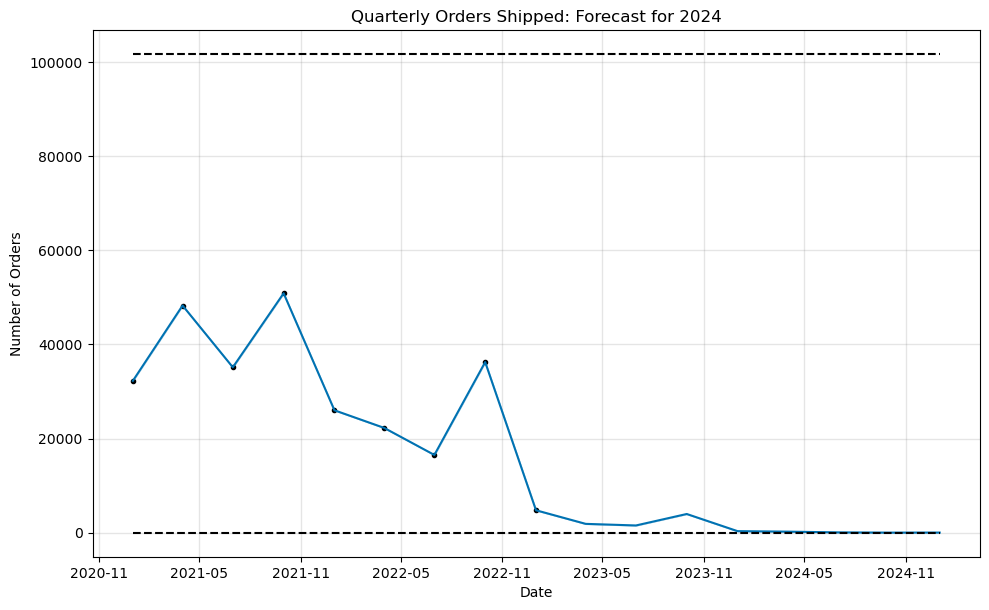

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

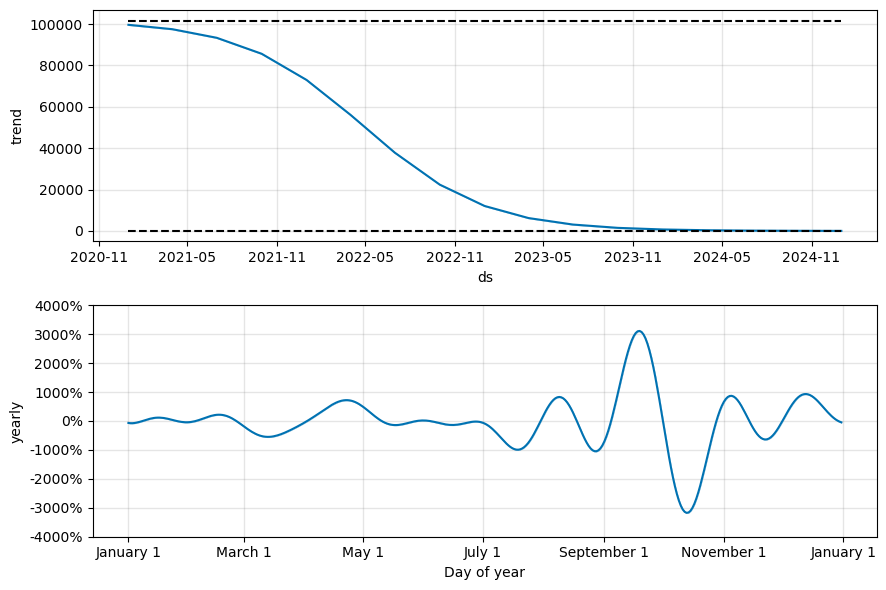

In [47]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to 0 to prevent negative predictions
quarterly_series['floor'] = 0
# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth AND multiplicative seasonality
m = Prophet(growth='logistic', seasonality_mode='multiplicative')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = 0
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray negative predictions in the main forecast and lower confidence interval to be 0
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


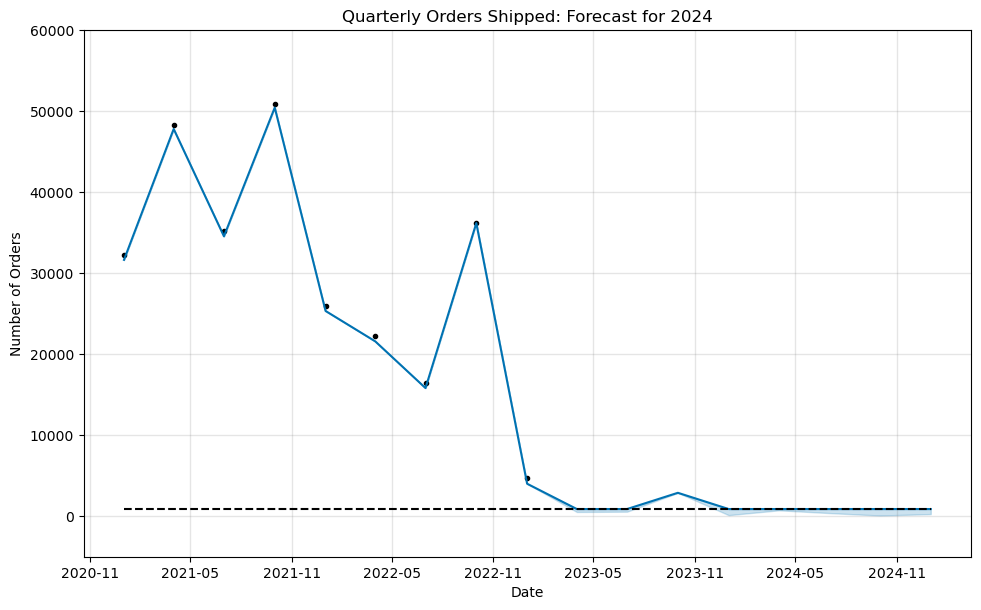

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

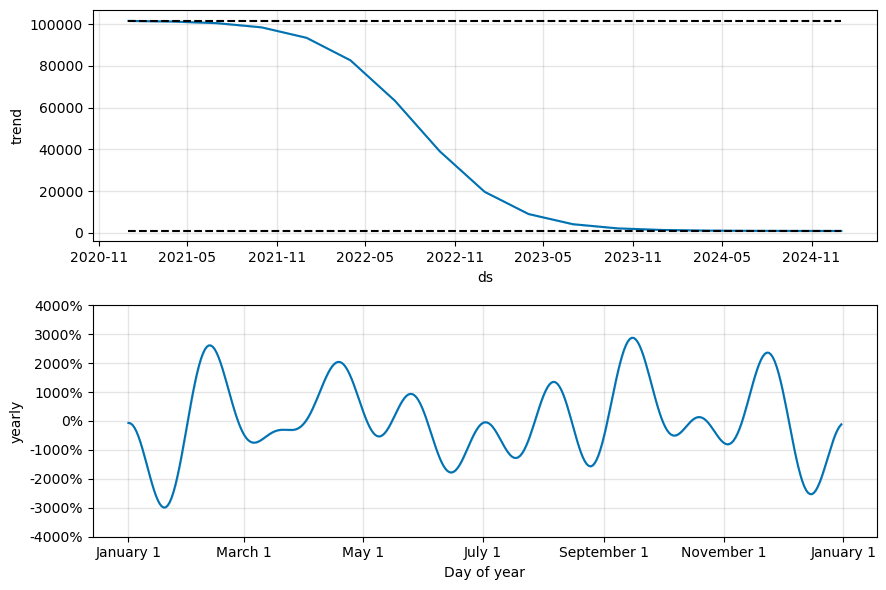

In [48]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = quarterly_series['y'].mean() * 0.03
quarterly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth to enforce the floor and cap, and multiplicative seasonality
m = Prophet(growth='logistic', seasonality_mode='multiplicative')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.ylim(top = 60000)
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


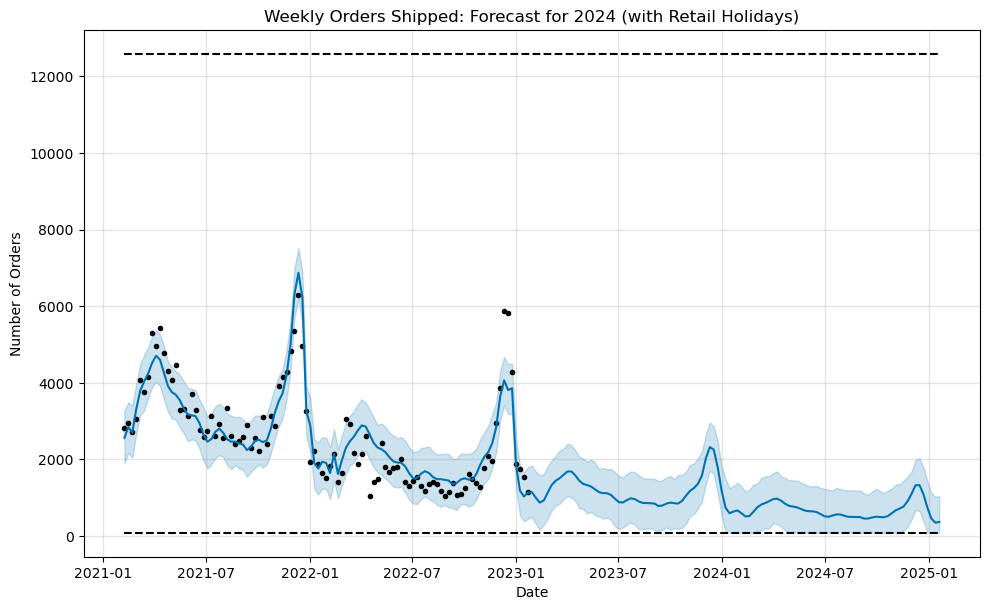

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

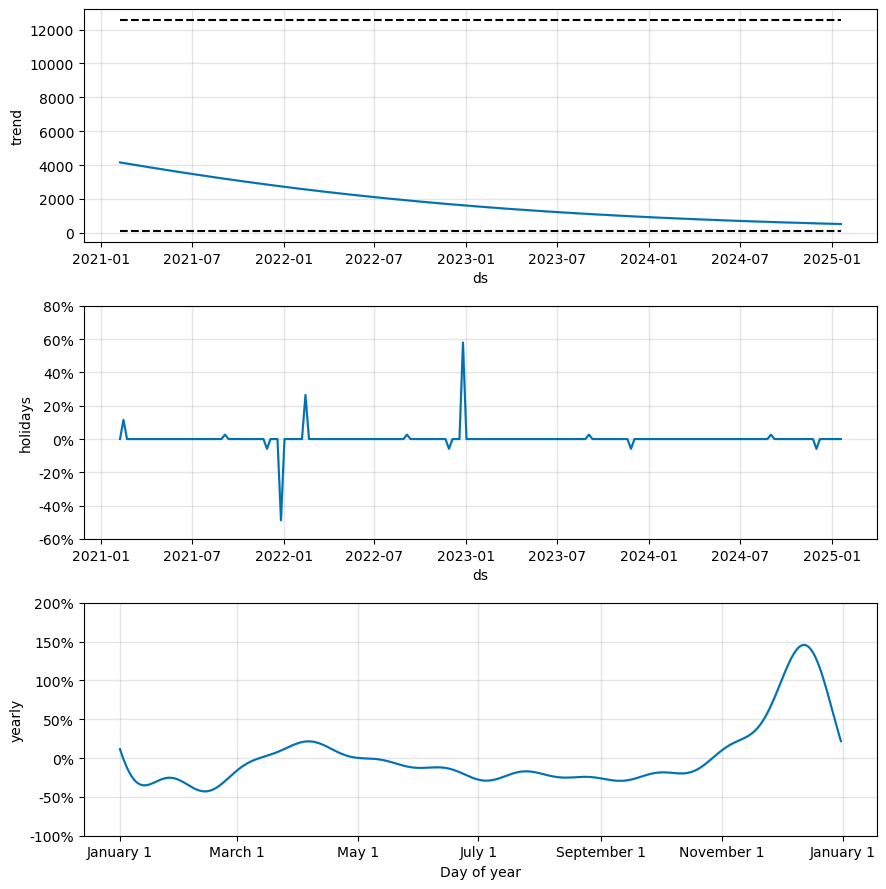

In [49]:
# 2. Resample to Weekly (W) to get weekly aggregate of orders
# We switch to weekly so holidays are not absorbed by quarterly seasonality
weekly_series = df_orders.resample('W', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
weekly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
weekly_series['ds'] = weekly_series['ds'].dt.tz_localize(None)

# FIX: Drop the final row because it is likely an incomplete week (e.g., ends on a Tuesday)
# This prevents the model from learning an artificial massive drop at the end of the training data
weekly_series = weekly_series.iloc[:-1].copy()

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = weekly_series['y'].mean() * 0.03
weekly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = weekly_series['y'].max()
weekly_series['cap'] = max_orders * 2

# Define the retail holidays for Fingerhut's specific inventory (2021-2024)
holidays_data = {
    'holiday': [
        'Black Friday', 'Black Friday', 'Black Friday', 'Black Friday',
        'Cyber Monday', 'Cyber Monday', 'Cyber Monday', 'Cyber Monday',
        'Christmas', 'Christmas', 'Christmas', 'Christmas',
        'Valentines', 'Valentines', 'Valentines', 'Valentines',
        'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day'
    ],
    'ds': pd.to_datetime([
        '2021-11-26', '2022-11-25', '2023-11-24', '2024-11-29', # Black Friday
        '2021-11-29', '2022-11-28', '2023-11-27', '2024-12-02', # Cyber Monday
        '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25', # Christmas
        '2021-02-14', '2022-02-14', '2023-02-14', '2024-02-14', # Valentines (Jewelry)
        '2021-09-06', '2022-09-05', '2023-09-04', '2024-09-02'  # Labor Day (Appliances)
    ]),
    'lower_window': -3, # Extends the holiday effect 3 days before
    'upper_window': 3   # Extends the holiday effect 3 days after to match the weekly grouping
}
retail_holidays = pd.DataFrame(holidays_data)

# 3. Fit the model using logistic growth, multiplicative seasonality, and retail holidays
# We forcefully set yearly_seasonality=True because our dataset is just barely under 730 days
m = Prophet(
    growth='logistic', 
    seasonality_mode='multiplicative', 
    holidays=retail_holidays,
    yearly_seasonality=True
)
m.fit(weekly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 104 weeks (2 years) into the future
future = m.make_future_dataframe(periods=104, freq='W')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (with Retail Holidays)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


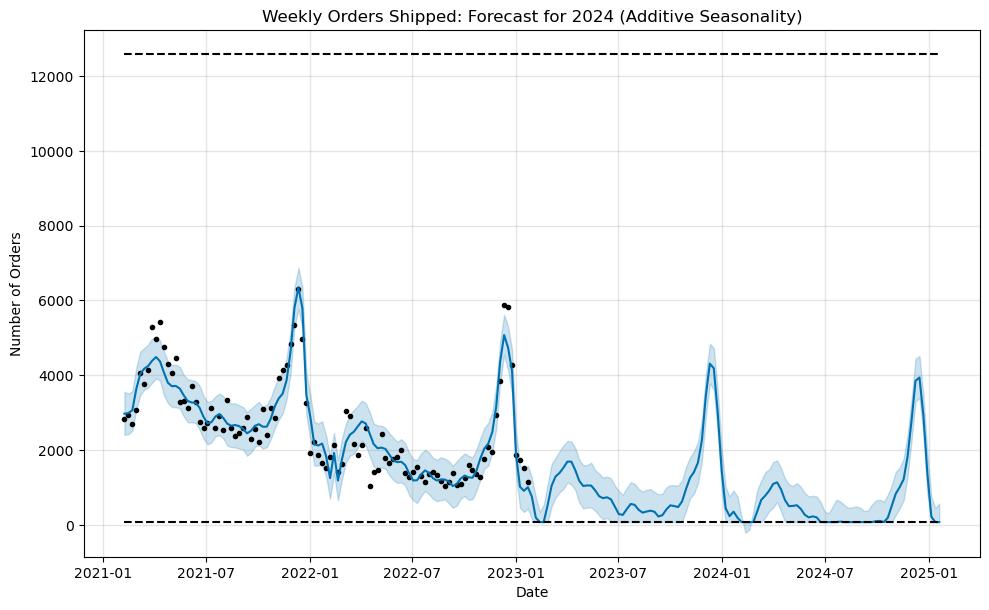

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

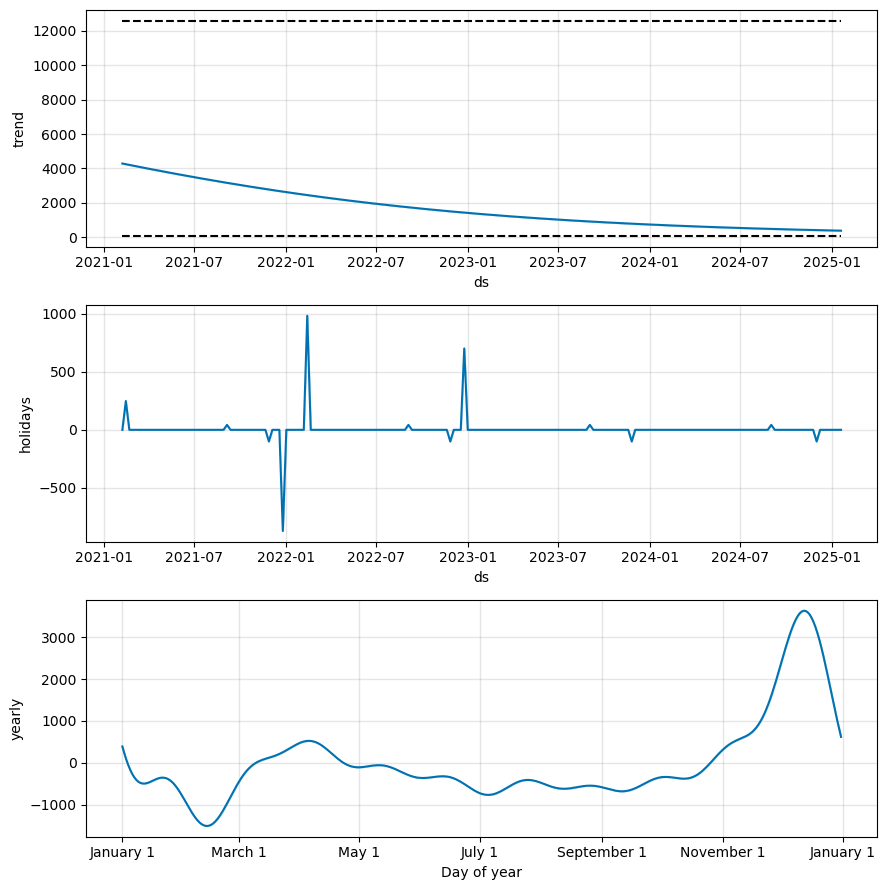

In [50]:
# 2. Resample to Weekly (W) to get weekly aggregate of orders
# We switch to weekly so holidays are not absorbed by quarterly seasonality
weekly_series = df_orders.resample('W', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
weekly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
weekly_series['ds'] = weekly_series['ds'].dt.tz_localize(None)

# FIX: Drop the final row because it is likely an incomplete week (e.g., ends on a Tuesday)
# This prevents the model from learning an artificial massive drop at the end of the training data
weekly_series = weekly_series.iloc[:-1].copy()

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = weekly_series['y'].mean() * 0.03
weekly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = weekly_series['y'].max()
weekly_series['cap'] = max_orders * 2

# Define the retail holidays for Fingerhut's specific inventory (2021-2024)
holidays_data = {
    'holiday': [
        'Black Friday', 'Black Friday', 'Black Friday', 'Black Friday',
        'Cyber Monday', 'Cyber Monday', 'Cyber Monday', 'Cyber Monday',
        'Christmas', 'Christmas', 'Christmas', 'Christmas',
        'Valentines', 'Valentines', 'Valentines', 'Valentines',
        'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day'
    ],
    'ds': pd.to_datetime([
        '2021-11-26', '2022-11-25', '2023-11-24', '2024-11-29', # Black Friday
        '2021-11-29', '2022-11-28', '2023-11-27', '2024-12-02', # Cyber Monday
        '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25', # Christmas
        '2021-02-14', '2022-02-14', '2023-02-14', '2024-02-14', # Valentines (Jewelry)
        '2021-09-06', '2022-09-05', '2023-09-04', '2024-09-02'  # Labor Day (Appliances)
    ]),
    'lower_window': -3, # Extends the holiday effect 3 days before
    'upper_window': 3   # Extends the holiday effect 3 days after to match the weekly grouping
}
retail_holidays = pd.DataFrame(holidays_data)

# 3. Fit the model using logistic growth, ADDITIVE seasonality, and retail holidays
# We forcefully set yearly_seasonality=True because our dataset is just barely under 730 days
m = Prophet(
    growth='logistic', 
    seasonality_mode='additive', 
    holidays=retail_holidays,
    yearly_seasonality=True
)
m.fit(weekly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 104 weeks (2 years) into the future
future = m.make_future_dataframe(periods=104, freq='W')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (Additive Seasonality)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

12:05:20 - cmdstanpy - INFO - Chain [1] start processing
12:05:20 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  447.491747   79.220680 1337.206686
2024-01-14  237.541143   79.220680 1023.687523
2024-01-21  357.586362   79.220680 1214.642635
2024-01-28  195.911495   79.220680 1005.076600
2024-02-04   79.220680   79.220680  562.082120
2024-02-11   79.220680   79.220680  129.153896
2024-02-18   79.220680   79.220680  178.885439
2024-02-25   79.220680   79.220680  699.296681
2024-03-03  371.198920   79.220680 1265.494277
2024-03-10  673.385395   79.220680 1545.449082
2024-03-17  785.638974   79.220680 1755.465185
2024-03-24  918.561653   79.220680 1786.350501
2024-03-31 1096.223703  140.391938 1939.045009
2024-04-07 1142.451521  267.797678 2003.122857
2024-04-14  953.757548  162.193142 1832.215328
2024-04-21  667.420103   79.220680 1471.333221
2024-04-28  505.113105   79.220680 1358.693666
2024-05-05  511.527868   79.220680 1387.893956
2024-05-12  530.407683   79.220680 1353.304874
2024-05-19  431.376447   79.220680 1273.887137
2024-05-26  2

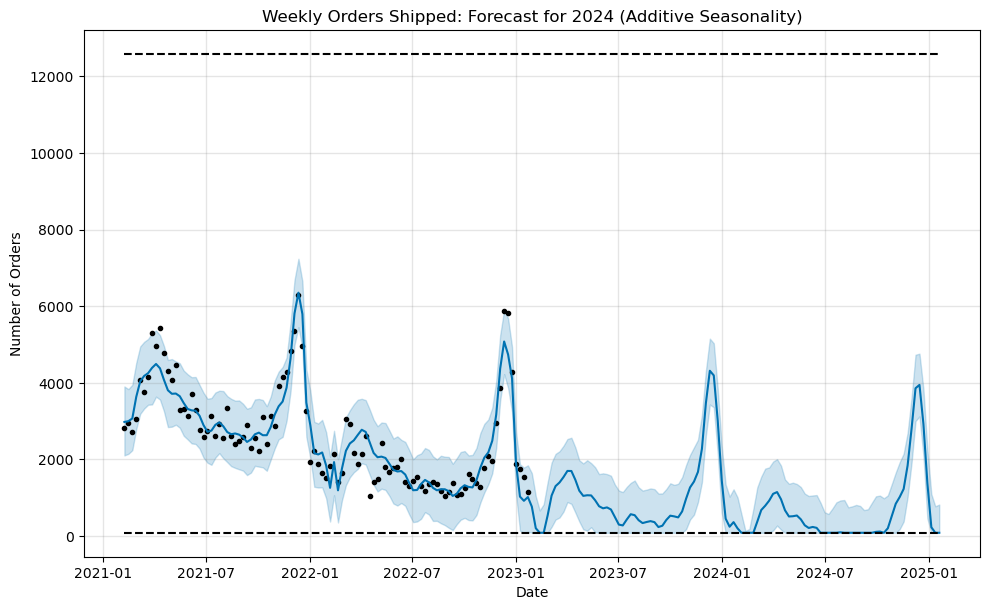

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

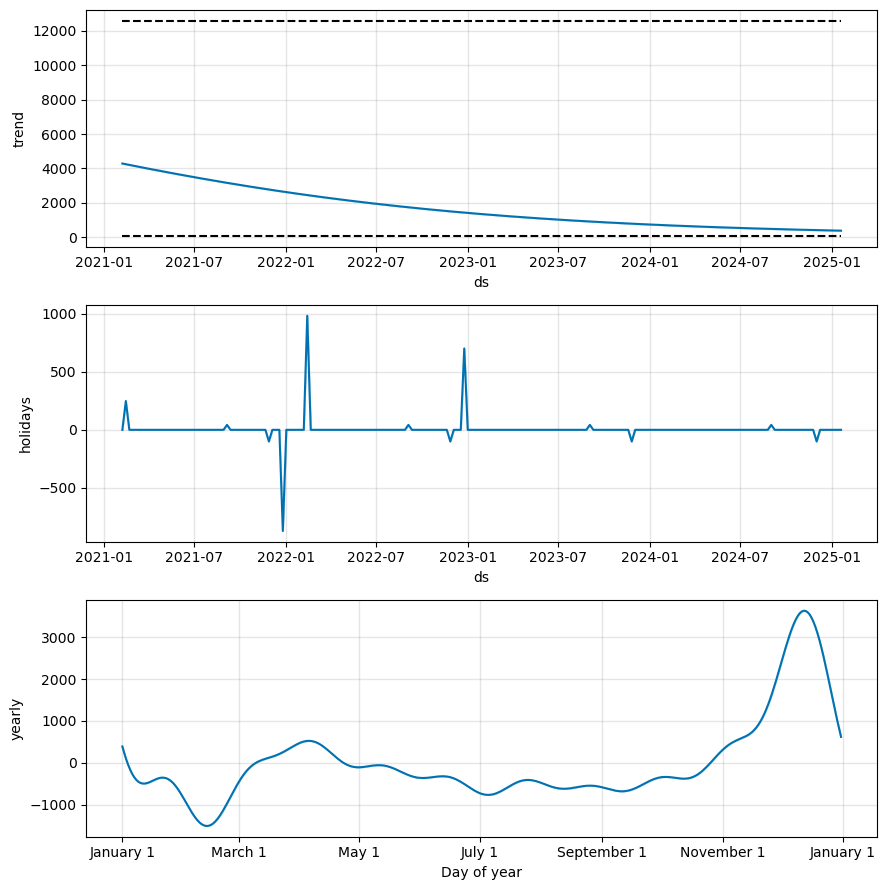

In [51]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... your preprocessing code up to retail_holidays ...

# 3. Fit the model with 95% intervals
m = Prophet(
    growth='logistic',
    seasonality_mode='additive',
    holidays=retail_holidays,
    yearly_seasonality=True,
    interval_width=0.95  # <--- key change for 95% CI
)
m.fit(weekly_series)

# 4. Forecast forward
future = m.make_future_dataframe(periods=104, freq='W')
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Keep predictions and intervals respecting the floor (and optionally cap)
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=baseline_orders)  # recommended

# 4b. Report predictions for 2024 only (weekly)
pred_2024 = forecast.loc[
    (forecast['ds'] >= '2024-01-01') & (forecast['ds'] < '2025-01-01'),
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
].copy()

pred_2024.rename(columns={
    'yhat': 'pred_mean',
    'yhat_lower': 'ci95_lower',
    'yhat_upper': 'ci95_upper'
}, inplace=True)

# Print the per-week outputs (mean + 95% CI)
print(pred_2024.to_string(index=False))

# Optional: a compact summary for the whole year (often nice to include)
summary_2024 = pd.Series({
    "avg_weekly_pred_mean_2024": pred_2024['pred_mean'].mean(),
    "avg_weekly_ci95_lower_2024": pred_2024['ci95_lower'].mean(),
    "avg_weekly_ci95_upper_2024": pred_2024['ci95_upper'].mean(),
    "total_predicted_orders_2024": pred_2024['pred_mean'].sum()
})
print("\n2024 prediction summary:")
print(summary_2024)

# Optional: save for grading / submission
pred_2024.to_csv("weekly_predictions_2024_with_ci95.csv", index=False)

# 5. Plot forecast (unchanged)
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (Additive Seasonality)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

fig2 = m.plot_components(forecast)
plt.show()


In [52]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(
    m,
    initial='365 days',     # train window
    period='90 days',       # spacing between cutoffs
    horizon='180 days'      # forecast horizon
)

df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mse', 'rmse', 'mae']])


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  2.97it/s]12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

    horizon           mse         rmse          mae
0   18 days  1.221358e+05   349.479334   292.775841
1   19 days  1.020808e+05   319.500812   266.744013
2   25 days  9.877219e+04   314.280438   248.682939
3   26 days  4.616982e+04   214.871643   167.250532
4   32 days  4.974633e+04   223.038848   172.402601
5   33 days  4.969529e+04   222.924402   169.544352
6   39 days  7.207017e+04   268.458873   198.116345
7   40 days  7.409464e+04   272.203307   210.990351
8   46 days  1.572939e+05   396.602951   318.297520
9   47 days  1.783346e+05   422.296802   343.211889
10  53 days  1.825024e+05   427.202993   371.729006
11  54 days  1.421163e+05   376.983127   301.423564
12  60 days  1.542343e+05   392.726778   333.249941
13  61 days  6.833342e+04   261.406626   207.533837
14  67 days  9.308172e+04   305.092973   230.378771
15  68 days  9.242662e+04   304.017474   228.013011
16  74 days  1.860223e+05   431.302999   344.343798
17  75 days  2.308668e+05   480.486023   399.367447
18  81 days 

In [53]:
(raw_lower_min, raw_lower_med) = (forecast['yhat_lower'].min(), forecast['yhat_lower'].median())
print("baseline_orders:", baseline_orders)
print("min yhat_lower after clip:", forecast['yhat_lower'].min())
print("fraction clipped:", (forecast['yhat_lower'] == baseline_orders).mean())


baseline_orders: 79.22067961165048
min yhat_lower after clip: 79.22067961165048
fraction clipped: 0.34782608695652173


In [54]:
forecast2 = m.predict(future)

pred_2024_raw = forecast2.loc[
    (forecast2['ds'] >= '2024-01-01') & (forecast2['ds'] < '2025-01-01'),
    ['ds','yhat','yhat_lower','yhat_upper']
]

print("baseline_orders:", baseline_orders)
print("fraction where raw lower < floor:", (pred_2024_raw['yhat_lower'] < baseline_orders).mean())
print(pred_2024_raw.head(10))


baseline_orders: 79.22067961165048
fraction where raw lower < floor: 0.7884615384615384
            ds        yhat   yhat_lower   yhat_upper
152 2024-01-07  447.491747  -345.034431  1260.634530
153 2024-01-14  237.541143  -697.609273  1102.648518
154 2024-01-21  357.586362  -488.625349  1255.464774
155 2024-01-28  195.911495  -675.573490  1088.535616
156 2024-02-04 -334.152915 -1220.725294   501.023270
157 2024-02-11 -779.034948 -1602.494783    94.103437
158 2024-02-18 -711.066903 -1644.909239   119.179995
159 2024-02-25 -188.676349  -960.364363   661.348536
160 2024-03-03  371.198920  -507.224409  1223.616402
161 2024-03-10  673.385395  -166.550611  1549.408617


# Task 3

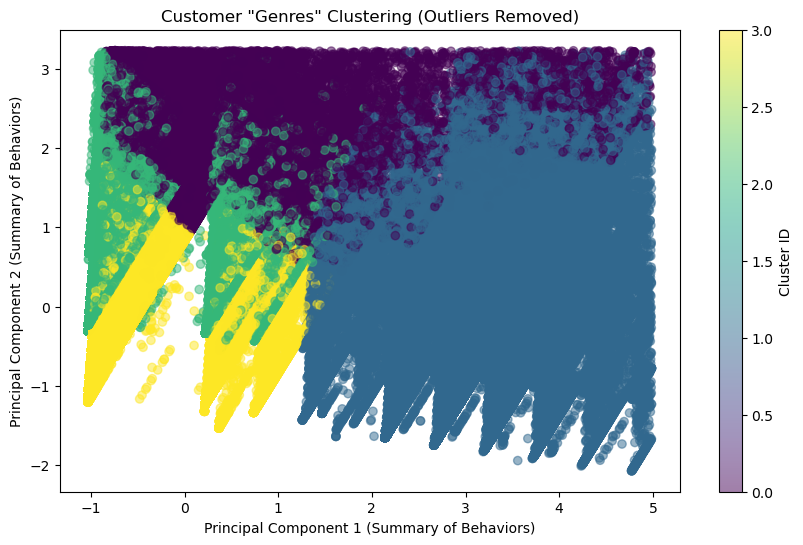

Average Stage Interactions per Cluster:
stage    Apply for Credit  Credit Account  Discover  Downpayment  \
cluster                                                            
0                   28.13            0.37      0.95         0.32   
1                    5.54            1.02      0.60         2.29   
2                    4.78            0.05      1.03         0.01   
3                    5.60            0.05      0.00         0.01   

stage    First Purchase  Order Shipped  
cluster                                 
0                113.83           0.11  
1                 38.27           0.97  
2                 13.68           0.00  
3                 14.48           0.00  


In [55]:
import pandas as pd
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Load the provided key mapping into a DataFrame
key_csv_data = """event_name,journey_id,event_definition_id,milestone_number,stage
application_phone_approved,1,15,1,Apply for Credit
application_phone_declined,1,16,,Apply for Credit
application_phone_pending,1,17,,Apply for Credit
application_web_approved,1,12,1,Apply for Credit
application_web_declined,1,13,,Apply for Credit
application_web_pending,1,14,,Apply for Credit
application_web_submit,1,3,,Apply for Credit
application_web_view,1,19,,Apply for Credit
account_activitation,1,29,3,Credit Account
account_fraud_review,1,37,,Credit Account
campaign_click,1,2,,Discover
customer_requested_catalog_digital,1,9,,Discover
fingerhut_university,1,10,,Discover
pre_application_3rd_party_affiliates,1,22,,Discover
site_registration,1,23,,Discover
account_downpaymentcleared,1,27,5,Downpayment
account_downpaymentreceived,1,26,,Downpayment
place_downpayment,1,8,4,Downpayment
place_downpayment_phone,1,25,4,Downpayment
add_to_cart,1,11,,First Purchase
begin_checkout,1,6,,First Purchase
browse_products,1,4,,First Purchase
place_order_phone,1,18,2,First Purchase
place_order_web,1,7,2,First Purchase
view_cart,1,5,,First Purchase
order_shipped,1,28,6,Order Shipped
catalog_email_experian,1,20,,Prospecting
catalog_mail,1,21,,Prospecting"""

df_key = pd.read_csv(io.StringIO(key_csv_data))

# 2. Merge the stages onto your clean tracking data
# df_clean is the dataframe after removing duplicates in Task 2
df_merged = df_clean.merge(df_key[['event_name', 'stage']], on='event_name', how='left')

# 3. Create a feature matrix: count of interactions per stage for each customer
customer_profiles = pd.crosstab(df_merged['customer_id'], df_merged['stage'])

# 4. Scale the features so stages with high volume do not dominate the distance metrics
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles)

# 5. Apply K-Means Clustering (starting with 4 clusters as a guess)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_profiles['cluster'] = kmeans.fit_predict(scaled_features)

import numpy as np
from scipy import stats

# 6. Reduce dimensions to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 7. Identify outliers using Z-scores on the PCA features
# Calculate the Z-score for each principal component
z_scores = np.abs(stats.zscore(pca_features))

# Define a threshold (e.g., 3 standard deviations from the mean)
threshold = 3

# Create a boolean mask to keep only the rows where both PCA components are within the threshold
# This filters out extreme outliers that stretch the plot
mask = (z_scores[:, 0] < threshold) & (z_scores[:, 1] < threshold)

# Apply the mask to our features and cluster labels
clean_pca_features = pca_features[mask]
clean_clusters = customer_profiles['cluster'].values[mask]

# 8. Plot the cleaned clusters
plt.figure(figsize=(10, 6))
plt.scatter(clean_pca_features[:, 0], clean_pca_features[:, 1], c=clean_clusters, cmap='viridis', alpha=0.5)
plt.title('Customer "Genres" Clustering (Outliers Removed)')
plt.xlabel('Principal Component 1 (Summary of Behaviors)')
plt.ylabel('Principal Component 2 (Summary of Behaviors)')
plt.colorbar(label='Cluster ID')
plt.show()

# 9. Output the average stage interactions per cluster to interpret the "genres"
cluster_summary = customer_profiles.groupby('cluster').mean()
print("Average Stage Interactions per Cluster:")
print(cluster_summary.round(2))

### Weekly model with additional CI info

12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing


        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  773.590878  535.502344 1106.693446
2024-01-14  680.509864  462.094976  992.474409
2024-01-21  651.915284  454.800213  935.001969
2024-01-28  604.543720  417.197529  893.262465
2024-02-04  529.984200  373.597427  768.999113
2024-02-11  478.669481  335.159584  689.607335
2024-02-18  486.893345  340.588209  721.714213
2024-02-25  553.861552  385.265230  792.383144
2024-03-03  644.290318  440.653613  934.499217
2024-03-10  709.119844  489.423438 1009.597997
2024-03-17  733.703219  515.762894 1053.484522
2024-03-24  738.863667  506.918286 1061.474262
2024-03-31  734.450539  499.281687 1031.286495
2024-04-07  708.604969  507.484345 1000.492080
2024-04-14  660.840459  460.165954  948.414295
2024-04-21  617.219169  424.409087  896.405913
2024-04-28  602.382517  408.366017  903.061118
2024-05-05  613.796320  418.503224  891.851776
2024-05-12  624.639686  430.050228  913.362954
2024-05-19  612.643797  418.914075  885.173478
2024-05-26  5

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


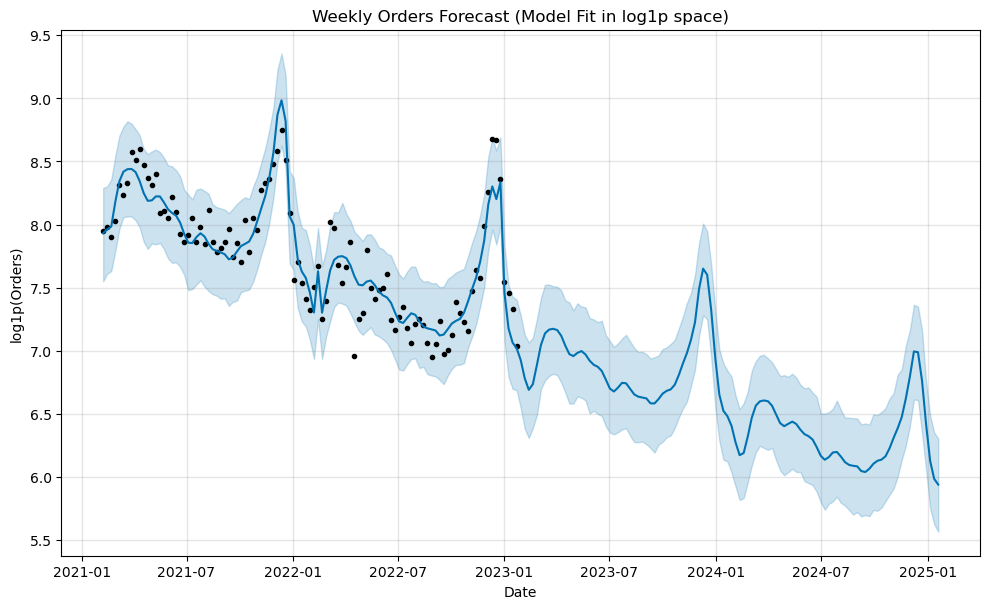

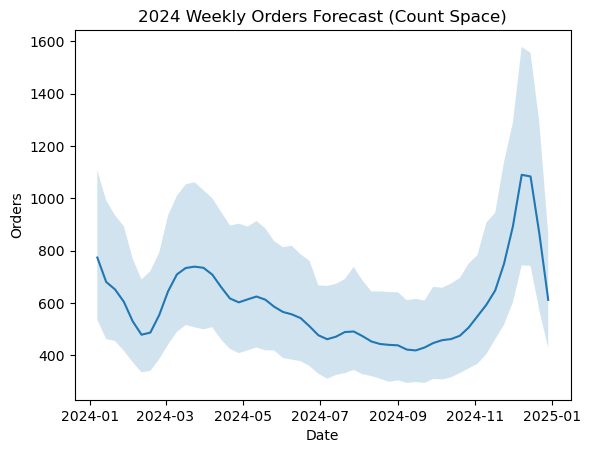

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

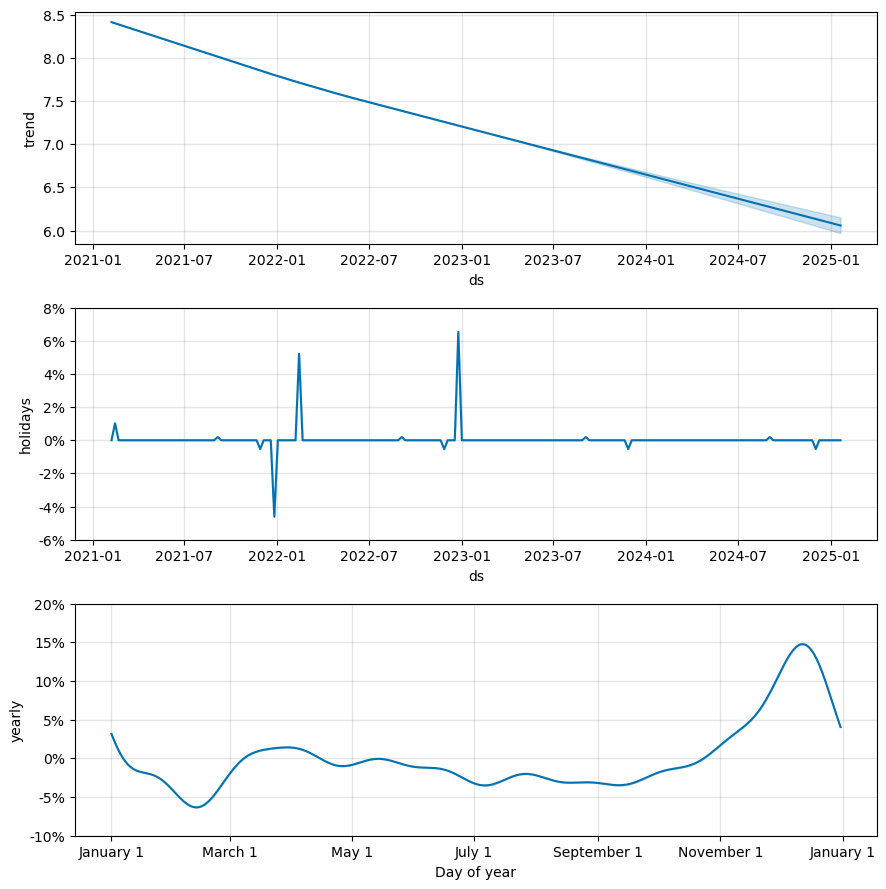

In [56]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# weekly_series must already exist with columns: ds, y
# retail_holidays must already exist

weekly = weekly_series.copy()

# 1) Transform target to stabilize variance and avoid negative forecasts
weekly['y_log'] = np.log1p(weekly['y'])

# Prophet expects target column to be named y
weekly_for_prophet = weekly[['ds', 'y_log']].rename(columns={'y_log': 'y'}).copy()

# 2) Fit model
m = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    holidays=retail_holidays,
    changepoint_prior_scale=0.01,   # smoother trend
    seasonality_prior_scale=5,
    holidays_prior_scale=5,
    interval_width=0.95
)
m.fit(weekly_for_prophet)

# 3) Forecast forward
future = m.make_future_dataframe(periods=104, freq='W')
forecast_log = m.predict(future)

# 4) Invert transform back to counts
forecast = forecast_log.copy()
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = np.expm1(forecast[col])

# counts should not be negative after inverse, but clip just in case
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=0)

# 5) Report 2024 predictions (mean + 95% CI)
pred_2024 = forecast.loc[
    (forecast['ds'] >= '2024-01-01') & (forecast['ds'] < '2025-01-01'),
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
].copy()

pred_2024.rename(columns={
    'yhat': 'pred_mean',
    'yhat_lower': 'ci95_lower',
    'yhat_upper': 'ci95_upper'
}, inplace=True)

print(pred_2024.to_string(index=False))

summary_2024 = pd.Series({
    "avg_weekly_pred_mean_2024": pred_2024['pred_mean'].mean(),
    "avg_weekly_ci95_lower_2024": pred_2024['ci95_lower'].mean(),
    "avg_weekly_ci95_upper_2024": pred_2024['ci95_upper'].mean(),
    "total_predicted_orders_2024": pred_2024['pred_mean'].sum()
})
print("\n2024 prediction summary:")
print(summary_2024)

pred_2024.to_csv("weekly_predictions_2024_with_ci95_log_model.csv", index=False)

# 6) Plots
fig1 = m.plot(forecast_log)  # plot in log space (Prophet internal)
plt.title('Weekly Orders Forecast (Model Fit in log1p space)')
plt.xlabel('Date')
plt.ylabel('log1p(Orders)')
plt.show()

# Optional: plot in original count space
plt.figure()
plt.plot(pred_2024['ds'], pred_2024['pred_mean'])
plt.fill_between(pred_2024['ds'], pred_2024['ci95_lower'], pred_2024['ci95_upper'], alpha=0.2)
plt.title('2024 Weekly Orders Forecast (Count Space)')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

fig2 = m.plot_components(forecast_log)
plt.show()


### Cross Validation Method

In [57]:
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd

# Build training data for Prophet (log model)
train_df = weekly_series[['ds', 'y']].copy()
train_df['y'] = np.log1p(train_df['y'])

# A small hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.02, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'holidays_prior_scale': [1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

results = []

for params in all_params:
    # m_cv = Prophet(
    #     growth='linear',
    #     yearly_seasonality=True,
    #     holidays=retail_holidays,
    #     interval_width=0.95,
    #     changepoint_prior_scale=params['changepoint_prior_scale'],
    #     seasonality_prior_scale=params['seasonality_prior_scale'],
    #     holidays_prior_scale=params['holidays_prior_scale'],
    #     seasonality_mode=params['seasonality_mode']
    # )
    m_cv = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        holidays=retail_holidays,
        changepoint_prior_scale=0.02,   # smoother trend
        seasonality_prior_scale=5,
        holidays_prior_scale=5,
        interval_width=0.95
    )

    m_cv.add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=5
)
    m_cv.fit(train_df)

    df_cv = cross_validation(
        m_cv,
        initial='365 days',
        period='90 days',
        horizon='180 days'
    )

    df_p = performance_metrics(df_cv)

    # This MSE is in log space since the model was fit in log space
    mean_mse = df_p['mse'].mean()

    results.append({
        **params,
        'cv_mse_log_space': mean_mse,
        'cv_rmse_log_space': df_p['rmse'].mean()
    })

results_df = pd.DataFrame(results).sort_values('cv_mse_log_space')
print(results_df.head(10).to_string(index=False))

best_params = results_df.iloc[0].to_dict()
print("\nBest params:")
print(best_params)


12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.45it/s]12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:40 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
12:06:40 - cmdstanpy - INFO - Chain [1] start processing
12:06:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]12:06:40 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.47it/s]12:06:41 - cmdsta

 changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale seasonality_mode  cv_mse_log_space  cv_rmse_log_space
                    0.01                      1.0                   1.0         additive          0.086856           0.219883
                    0.05                      1.0                  10.0         additive          0.086856           0.219883
                    0.05                      1.0                  10.0   multiplicative          0.086856           0.219883
                    0.05                      5.0                   1.0         additive          0.086856           0.219883
                    0.05                      5.0                   1.0   multiplicative          0.086856           0.219883
                    0.05                      5.0                  10.0         additive          0.086856           0.219883
                    0.05                      5.0                  10.0   multiplicative          0.086856           0

In [58]:
df_cv_counts = df_cv.copy()
df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])

mse_count_space = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
print("CV MSE in count space:", mse_count_space)


CV MSE in count space: 691908.3194075581


### Feature selection

In [59]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from itertools import product

train_df = weekly_series[['ds','y']].copy()
train_df['y'] = np.log1p(train_df['y'])

grid = {
    "seasonality_mode": ["additive", "multiplicative"],
    "use_quarterly": [False, True],
    "changepoint_prior_scale": [0.01, 0.02, 0.05],
    "use_holidays": [True, False],  # set to [True] if you want fewer runs
}

rows = []

for seasonality_mode, use_quarterly, cps, use_holidays in product(
    grid["seasonality_mode"],
    grid["use_quarterly"],
    grid["changepoint_prior_scale"],
    grid["use_holidays"]
):
    m = Prophet(
        growth="linear",
        yearly_seasonality=True,
        seasonality_mode=seasonality_mode,
        holidays=retail_holidays if use_holidays else None,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=5,
        holidays_prior_scale=5,
        interval_width=0.95
    )

    if use_quarterly:
        m.add_seasonality(name="quarterly", period=365.25/4, fourier_order=5)

    m.fit(train_df)

    df_cv = cross_validation(m, initial="365 days", period="90 days", horizon="180 days")
    df_cv_tmp = df_cv.copy()
    df_cv_tmp["y_count"] = np.expm1(df_cv_tmp["y"])
    df_cv_tmp["yhat_count"] = np.expm1(df_cv_tmp["yhat"])
    mse_count = np.mean((df_cv_tmp["y_count"] - df_cv_tmp["yhat_count"])**2)
    rmse_count = np.sqrt(mse_count)

    df_p = performance_metrics(df_cv)

    rows.append({
        "seasonality_mode": seasonality_mode,
        "use_quarterly": use_quarterly,
        "changepoint_prior_scale": cps,
        "use_holidays": use_holidays,
        "mse_log": df_p["mse"].mean(),
        "rmse_log": df_p["rmse"].mean()
    })

results = pd.DataFrame(rows).sort_values("mse_log")
print(results.head(10).to_string(index=False))


12:07:43 - cmdstanpy - INFO - Chain [1] start processing
12:07:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]12:07:43 - cmdstanpy - INFO - Chain [1] start processing
12:07:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  2.67it/s]12:07:43 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.72it/s]
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  2.99it/s]12:07:44 - cmdsta

seasonality_mode  use_quarterly  changepoint_prior_scale  use_holidays  mse_log  rmse_log
        additive           True                     0.01         False 0.069624  0.200739
        additive           True                     0.02         False 0.069669  0.200765
        additive          False                     0.02         False 0.076585  0.224178
        additive          False                     0.01         False 0.077386  0.225050
  multiplicative           True                     0.01         False 0.078167  0.210797
  multiplicative           True                     0.02         False 0.078320  0.210818
        additive           True                     0.02          True 0.078916  0.210684
        additive           True                     0.01          True 0.079160  0.210404
        additive          False                     0.01          True 0.081921  0.233040
        additive          False                     0.02          True 0.082229  0.233389


12:08:02 - cmdstanpy - INFO - Chain [1] start processing


12:08:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]12:08:03 - cmdstanpy - INFO - Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  4.14it/s]12:08:03 - cmdstanpy - INFO - Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  4.03it/s]
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pyd

Cross-Validated MSE (count space): 579543.880979092
Cross-Validated RMSE (count space): 761.2777948811406
        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  877.051878  614.176197 1277.636536
2024-01-14  720.014766  499.819591 1020.231453
2024-01-21  590.805870  425.174091  855.743713
2024-01-28  559.217679  389.716578  790.154219
2024-02-04  571.061524  399.498394  804.189034
2024-02-11  561.385459  389.256426  815.018927
2024-02-18  497.325076  364.249827  699.801544
2024-02-25  516.258483  354.991008  757.921529
2024-03-03  685.546271  486.752699  952.758617
2024-03-10  810.115511  572.153533 1148.125134
2024-03-17  795.168514  568.973680 1124.731707
2024-03-24  738.912292  516.051837 1059.319393
2024-03-31  745.138221  527.890295 1061.448217
2024-04-07  818.812325  571.596475 1166.143877
2024-04-14  732.977805  530.317200 1053.261543
2024-04-21  584.810480  412.804106  844.739696
2024-04-28  570.826981  402.828638  817.302745
2024-05-05  663.311791  455.517307  947.930314
2

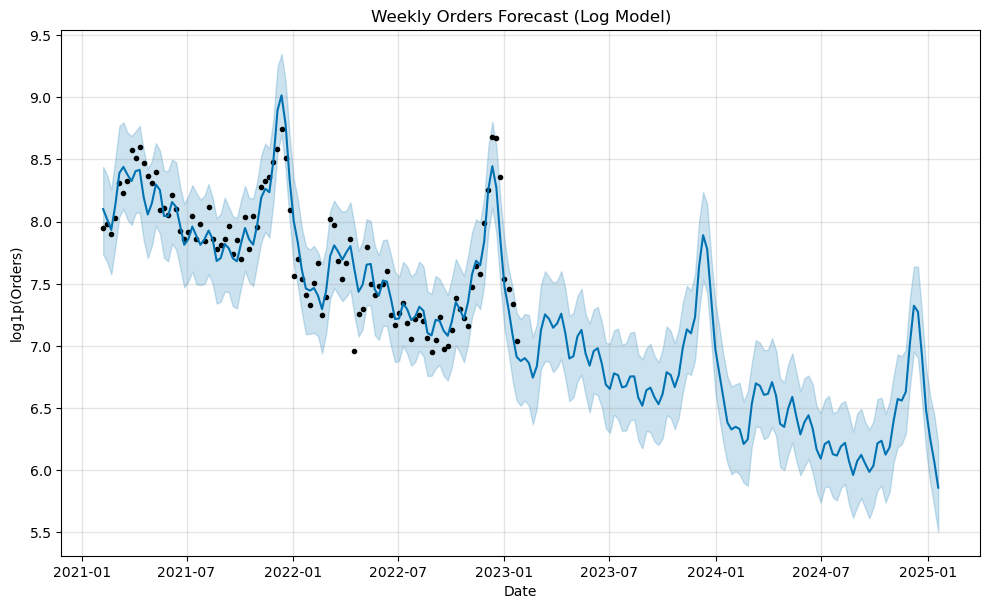

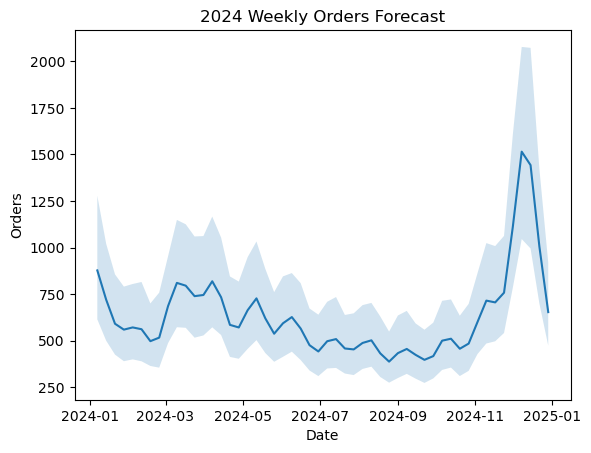

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

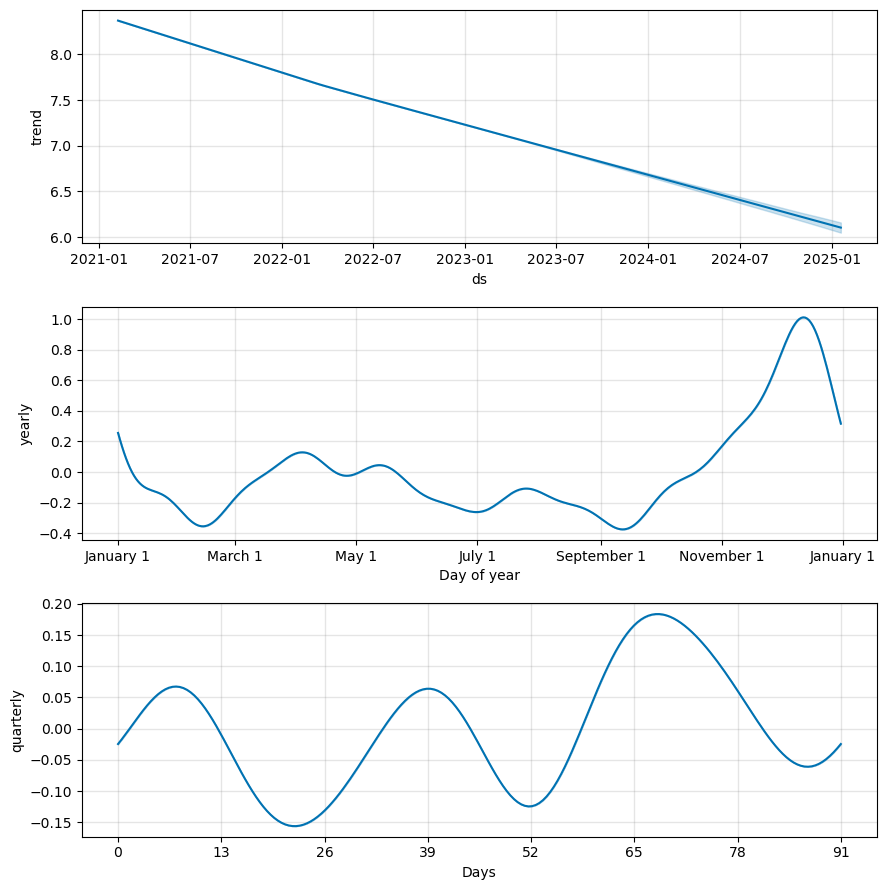

In [60]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Prepare data (log transform)
# -----------------------------

train_df = weekly_series[['ds', 'y']].copy()
train_df['y'] = np.log1p(train_df['y'])

# -----------------------------
# 2. Define final Prophet model
# -----------------------------

m = Prophet(
    growth='linear',
    seasonality_mode='additive',
    yearly_seasonality=True,
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=5,
    interval_width=0.95
)

# Add quarterly seasonality
m.add_seasonality(
    name='quarterly',
    period=365.25 / 4,
    fourier_order=5
)

# Fit model
m.fit(train_df)

# -----------------------------
# 3. Cross-validation evaluation
# -----------------------------

df_cv = cross_validation(
    m,
    initial='365 days',
    period='90 days',
    horizon='180 days'
)

df_p = performance_metrics(df_cv)

# Convert CV predictions back to count space
df_cv_counts = df_cv.copy()
df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])

mse_count = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
rmse_count = np.sqrt(mse_count)

print("Cross-Validated MSE (count space):", mse_count)
print("Cross-Validated RMSE (count space):", rmse_count)

# -----------------------------
# 4. Forecast 2024
# -----------------------------

future = m.make_future_dataframe(periods=104, freq='W')
forecast_log = m.predict(future)

# Convert forecast back to counts
forecast = forecast_log.copy()
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = np.expm1(forecast[col]).clip(lower=0)

# Extract 2024 predictions
pred_2024 = forecast.loc[
    (forecast['ds'] >= '2024-01-01') &
    (forecast['ds'] < '2025-01-01'),
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
].copy()

pred_2024.rename(columns={
    'yhat': 'pred_mean',
    'yhat_lower': 'ci95_lower',
    'yhat_upper': 'ci95_upper'
}, inplace=True)

print(pred_2024.to_string(index=False))

# -----------------------------
# 5. Plot results
# -----------------------------

fig1 = m.plot(forecast_log)
plt.title('Weekly Orders Forecast (Log Model)')
plt.xlabel('Date')
plt.ylabel('log1p(Orders)')
plt.show()

plt.figure()
plt.plot(pred_2024['ds'], pred_2024['pred_mean'])
plt.fill_between(
    pred_2024['ds'],
    pred_2024['ci95_lower'],
    pred_2024['ci95_upper'],
    alpha=0.2
)
plt.title('2024 Weekly Orders Forecast')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

fig2 = m.plot_components(forecast_log)
plt.show()


In [61]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def prophet_forecast_with_scale(
    series_df: pd.DataFrame,
    freq: str = "W",                      # "D", "W", "M", "Q"
    periods: int | None = None,           # if None, set sensible default by freq
    report_year: int = 2024,
    log_transform: bool = True,
    clip_nonnegative: bool = True,
    interval_width: float = 0.95,
    changepoint_prior_scale: float = 0.01,
    seasonality_prior_scale: float = 5.0,
    seasonality_mode: str = "additive",   # "additive" or "multiplicative"
    add_quarterly_seasonality: bool = True,
    quarterly_fourier_order: int = 5,
    cv_initial: str | None = None,
    cv_period: str | None = None,
    cv_horizon: str | None = None,
):
    """
    series_df must have columns: ['ds','y'] already aggregated at the desired grain OR raw.
    This function:
      1) optionally re-resamples to freq (if ds not already on that freq, it will aggregate)
      2) fits Prophet
      3) runs CV and prints MSE/RMSE in count space
      4) forecasts forward and prints report_year predictions with CI
      5) plots forecast + components + report_year chart
    """

    # -----------------------------
    # 0) Resample/aggregate to desired frequency
    # -----------------------------
    df = series_df[['ds', 'y']].copy()
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

    # If the input is event-level counts already aggregated, resampling with sum is safe.
    # If your df has one row per event, set y=1 before calling this function.
    df = (
        df.set_index('ds')
          .resample(freq)['y']
          .sum()
          .reset_index()
    )

    # Drop last row (often incomplete period)
    if len(df) > 1:
        df = df.iloc[:-1].copy()

    # -----------------------------
    # 1) Prepare training data
    # -----------------------------
    train_df = df.copy()
    if log_transform:
        train_df['y'] = np.log1p(train_df['y'])

    # -----------------------------
    # 2) Sensible defaults by frequency
    # -----------------------------
    if periods is None:
        periods = {"D": 730, "W": 104, "M": 24, "Q": 8}.get(freq, 104)

    if cv_initial is None or cv_period is None or cv_horizon is None:
        defaults = {
            "D": ("365 days", "90 days", "180 days"),
            "W": ("365 days", "90 days", "180 days"),
            "M": ("365 days", "30 days", "90 days"),
            "Q": ("730 days", "90 days", "180 days"),
        }
        d_init, d_period, d_horizon = defaults.get(freq, ("365 days", "90 days", "180 days"))
        cv_initial = cv_initial or d_init
        cv_period = cv_period or d_period
        cv_horizon = cv_horizon or d_horizon

    # -----------------------------
    # 3) Define and fit model
    # -----------------------------
    m = Prophet(
        growth='linear',
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        interval_width=interval_width
    )

    if add_quarterly_seasonality:
        m.add_seasonality(
            name='quarterly',
            period=365.25 / 4,
            fourier_order=quarterly_fourier_order
        )

    m.fit(train_df)

    # -----------------------------
    # 4) Cross-validation evaluation
    # -----------------------------
    df_cv = cross_validation(
        m,
        initial=cv_initial,
        period=cv_period,
        horizon=cv_horizon
    )
    df_p = performance_metrics(df_cv)

    # Convert CV back to count space if log-transformed
    if log_transform:
        df_cv_counts = df_cv.copy()
        df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
        df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])
        mse_count = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
        rmse_count = np.sqrt(mse_count)
    else:
        mse_count = df_p['mse'].mean()
        rmse_count = df_p['rmse'].mean()

    print(f"Frequency: {freq}")
    print("Cross-Validated MSE (count space):", mse_count)
    print("Cross-Validated RMSE (count space):", rmse_count)

    # -----------------------------
    # 5) Forecast forward
    # -----------------------------
    future = m.make_future_dataframe(periods=periods, freq=freq)
    forecast_pred = m.predict(future)

    # Convert forecast back to count space if log-transformed
    forecast = forecast_pred.copy()
    if log_transform:
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast[col] = np.expm1(forecast[col])

    if clip_nonnegative:
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast[col] = forecast[col].clip(lower=0)

    # Extract report_year predictions
    start = pd.Timestamp(f'{report_year}-01-01')
    end = pd.Timestamp(f'{report_year+1}-01-01')
    pred_year = forecast.loc[
        (forecast['ds'] >= start) & (forecast['ds'] < end),
        ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    ].copy()

    pred_year.rename(columns={
        'yhat': 'pred_mean',
        'yhat_lower': 'ci95_lower',
        'yhat_upper': 'ci95_upper'
    }, inplace=True)

    print(f"\n{report_year} Predictions with {int(interval_width*100)}% CI ({freq}):")
    print(pred_year.to_string(index=False))

    # -----------------------------
    # 6) Plots
    # -----------------------------
    # Prophet's built-in plot (in model space if log_transform else count space)
    fig1 = m.plot(forecast_pred)
    plt.title(f'Orders Forecast (freq={freq}, model_space={"log" if log_transform else "count"})')
    plt.xlabel('Date')
    plt.ylabel('log1p(Orders)' if log_transform else 'Orders')
    plt.show()

    # Clean plot in count space for report_year
    plt.figure()
    plt.plot(pred_year['ds'], pred_year['pred_mean'])
    plt.fill_between(pred_year['ds'], pred_year['ci95_lower'], pred_year['ci95_upper'], alpha=0.2)
    plt.title(f'{report_year} Orders Forecast (freq={freq}, count space)')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.show()

    # Components plot (still in model space)
    fig2 = m.plot_components(forecast_pred)
    plt.show()

    return {
        "model": m,
        "train_series": df,           # resampled series in count space
        "forecast": forecast,         # forecast in count space
        "pred_year": pred_year,       # year slice in count space
        "mse": float(mse_count),
        "rmse": float(rmse_count),
        "cv_metrics": df_p
    }


/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_10648/1463039648.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(freq)['y']
12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/8 [00:00<?, ?it/s]12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:00<00:01,  3.53it/s]12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 2/8 [00:00<00:01,  3.59it/s]12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:00<00:01,  3.66it/s]12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:14 -

Frequency: M
Cross-Validated MSE (count space): 2663880028.419693
Cross-Validated RMSE (count space): 51612.789388093464

2024 Predictions with 95% CI (M):
        ds  pred_mean  ci95_lower  ci95_upper
2024-01-31 248.878686  246.569279  251.270478
2024-02-29   0.000000    0.000000    0.000000
2024-03-31   0.000000    0.000000    0.000000
2024-04-30   0.000000    0.000000    0.000000
2024-05-31   0.000000    0.000000    0.000000
2024-06-30   0.000000    0.000000    0.000000
2024-07-31   0.000000    0.000000    0.000000
2024-08-31   0.000000    0.000000    0.000000
2024-09-30   0.000000    0.000000    0.000000
2024-10-31   0.000000    0.000000    0.000000
2024-11-30   0.000000    0.000000    0.000000
2024-12-31   0.000000    0.000000    0.000000


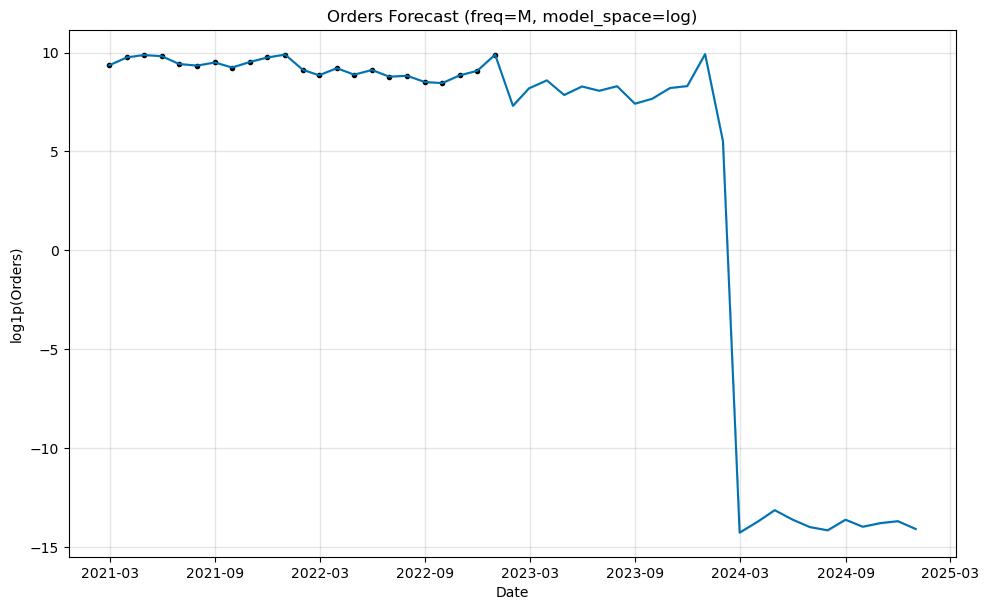

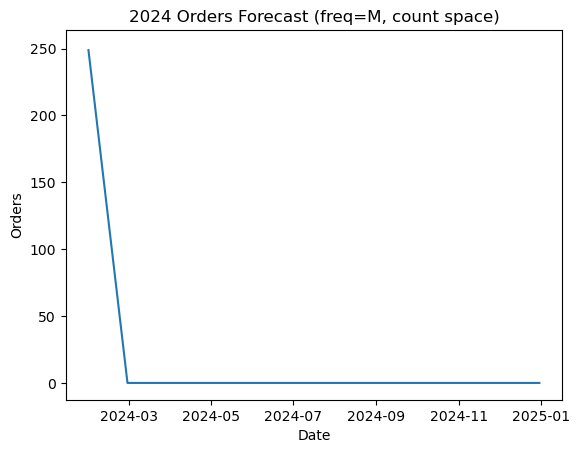

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

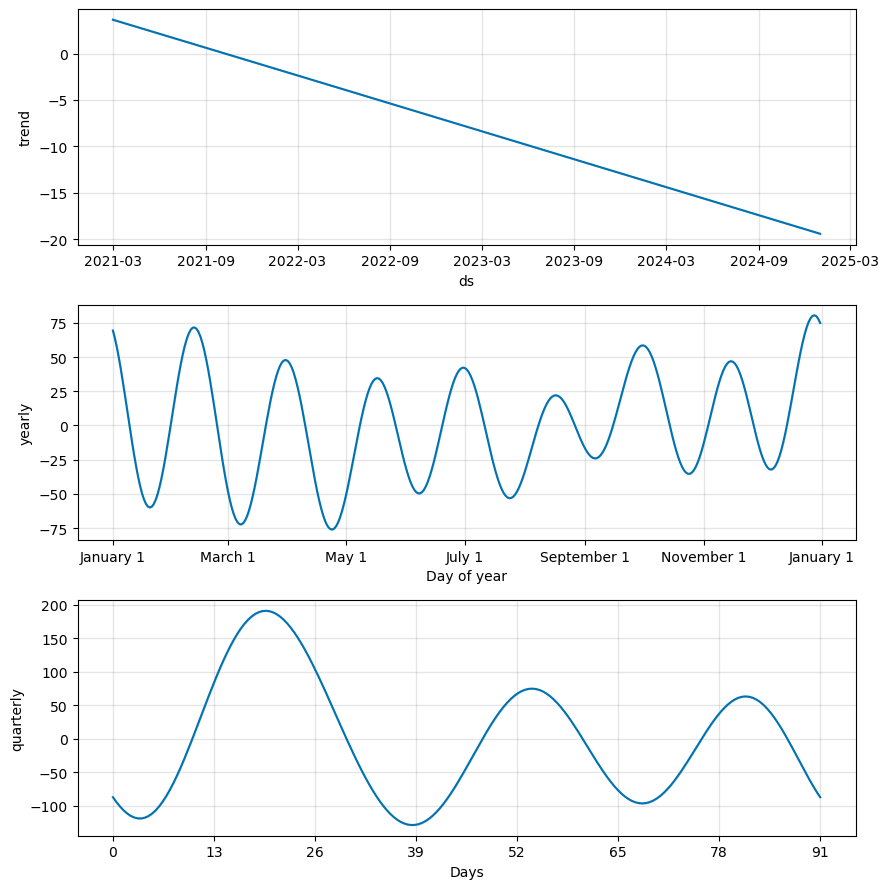

In [62]:
out_monthly = prophet_forecast_with_scale(weekly_series, freq="M", cv_horizon="90 days")

12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  4.43it/s]12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  4.35it/s]
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73:

Frequency: W
Cross-Validated MSE (count space): 579389.133236536
Cross-Validated RMSE (count space): 761.1761512531353

2024 Predictions with 95% CI (W):
        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  857.960424  595.673020 1222.183812
2024-01-14  690.932214  485.777561  966.944503
2024-01-21  548.106616  379.144134  780.161752
2024-01-28  522.775402  360.173488  757.264972
2024-02-04  548.793454  388.439763  775.817495
2024-02-11  545.516048  381.652006  777.998145
2024-02-18  486.942612  341.723315  692.760026
2024-02-25  502.492294  342.025134  709.952759
2024-03-03  663.777893  467.045904  945.369364
2024-03-10  786.248219  549.949104 1126.630242
2024-03-17  772.426541  544.109628 1093.454289
2024-03-24  720.546220  506.746210 1031.001026
2024-03-31  722.299604  503.827712 1048.870244
2024-04-07  795.453764  562.200376 1152.359654
2024-04-14  715.631583  510.719605 1006.647778
2024-04-21  563.891523  404.037667  799.851599
2024-04-28  554.286287  388.099904  792.375881


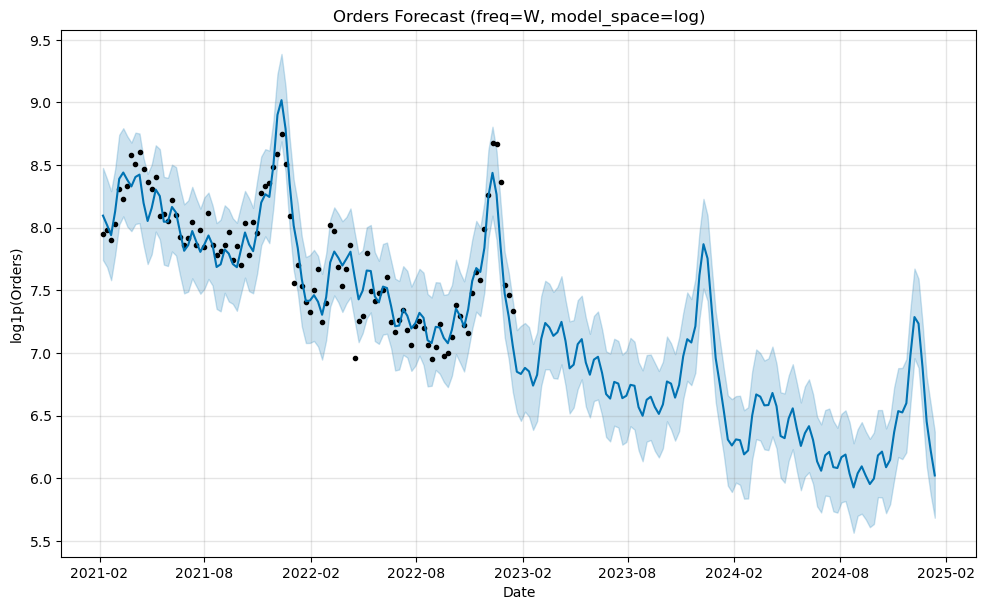

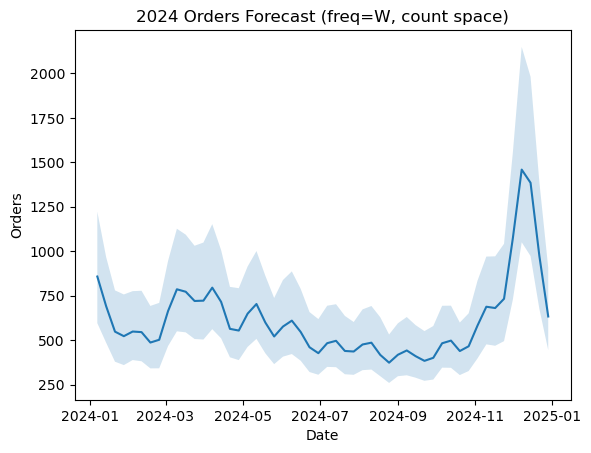

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

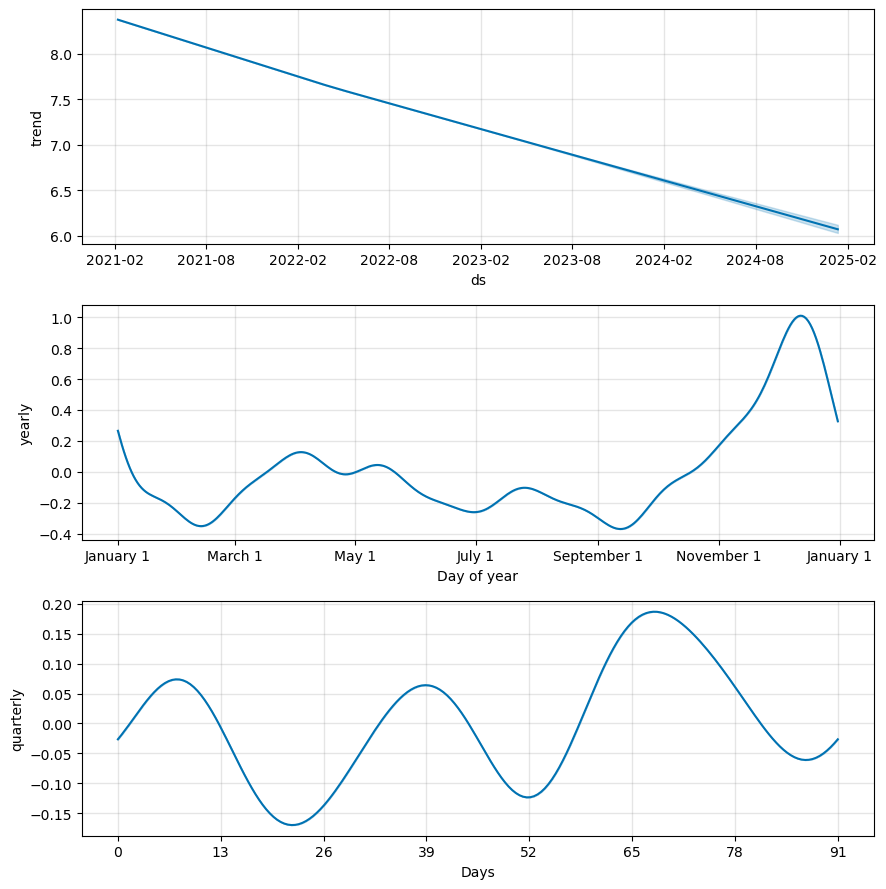

In [63]:
out_weekly = prophet_forecast_with_scale(weekly_series, freq="W")


In [64]:
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np

def tune_monthly_prophet_smoothness(
    df_orders: pd.DataFrame,
    timestamp_col: str = "event_timestamp",
    use_log1p: bool = False,                 # recommend False for monthly unless you really want it
    add_quarterly_seasonality: bool = True,
    quarterly_fourier_order: int = 5,
    interval_width: float = 0.95,
    # CV windows for monthly (adjust if you have lots of history)
    cv_initial: str = "365 days",
    cv_period: str = "30 days",
    cv_horizon: str = "90 days",
    # Hyperparameter grid (smoothness)
    changepoint_prior_scale_grid = (0.001, 0.01, 0.02, 0.05, 0.1),
    seasonality_prior_scale_grid = (0.5, 1.0, 5.0, 10.0),
    seasonality_mode_grid = ("additive", "multiplicative"),
    drop_last_row: bool = True,
):
    # -----------------------------
    # 1) Monthly aggregation
    # -----------------------------
    monthly_series = (
        df_orders
        .resample("M", on=timestamp_col)
        .size()
        .reset_index(name="y")
        .rename(columns={timestamp_col: "ds"})
    )
    monthly_series["ds"] = pd.to_datetime(monthly_series["ds"]).dt.tz_localize(None)
    if drop_last_row and len(monthly_series) > 1:
        monthly_series = monthly_series.iloc[:-1].copy()

    train_df = monthly_series[["ds", "y"]].copy()
    if use_log1p:
        train_df["y"] = np.log1p(train_df["y"])

    # -----------------------------
    # 2) Grid search with CV
    # -----------------------------
    results = []
    combos = list(product(changepoint_prior_scale_grid, seasonality_prior_scale_grid, seasonality_mode_grid))

    for cps, sps, smode in combos:
        m = Prophet(
            growth="linear",
            yearly_seasonality=True,
            seasonality_mode=smode,
            changepoint_prior_scale=float(cps),
            seasonality_prior_scale=float(sps),
            interval_width=interval_width,
        )

        if add_quarterly_seasonality:
            m.add_seasonality(
                name="quarterly",
                period=365.25 / 4,
                fourier_order=quarterly_fourier_order,
            )

        m.fit(train_df)

        df_cv = cross_validation(
            m,
            initial=cv_initial,
            period=cv_period,
            horizon=cv_horizon,
        )

        # Count-space MSE/RMSE
        if use_log1p:
            y_true = np.expm1(df_cv["y"].values)
            y_pred = np.expm1(df_cv["yhat"].values)
        else:
            y_true = df_cv["y"].values
            y_pred = df_cv["yhat"].values

        mse = float(np.mean((y_true - y_pred) ** 2))
        rmse = float(np.sqrt(mse))

        results.append({
            "changepoint_prior_scale": float(cps),
            "seasonality_prior_scale": float(sps),
            "seasonality_mode": smode,
            "mse_count": mse,
            "rmse_count": rmse,
        })

    results_df = pd.DataFrame(results).sort_values("mse_count").reset_index(drop=True)
    best_params = results_df.iloc[0].to_dict()

    return results_df, best_params, monthly_series


In [65]:
results_df, best_params, monthly_series = tune_monthly_prophet_smoothness(
    df_orders,
    use_log1p=False,          # recommended for monthly
    cv_initial="365 days",
    cv_period="30 days",
    cv_horizon="90 days"
)

print(results_df.head(10).to_string(index=False))
print("\nBest params:", best_params)


/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_10648/3369399624.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on=timestamp_col)
12:11:57 - cmdstanpy - INFO - Chain [1] start processing
12:11:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/8 [00:00<?, ?it/s]12:11:57 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:00<00:02,  3.36it/s]12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 2/8 [00:00<00:01,  4.00it/s]12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:00<00:01,  3.19it/s]12:11:58 - cmdstanpy - INFO - Chain [1] start processin

 changepoint_prior_scale  seasonality_prior_scale seasonality_mode    mse_count  rmse_count
                   0.100                      0.5   multiplicative 8.112893e+06 2848.313998
                   0.050                      0.5   multiplicative 8.650398e+06 2941.155890
                   0.100                      1.0   multiplicative 9.382366e+06 3063.064736
                   0.050                      1.0   multiplicative 9.922243e+06 3149.959268
                   0.001                      0.5   multiplicative 1.001698e+07 3164.961169
                   0.020                      0.5   multiplicative 1.012606e+07 3182.147217
                   0.010                      0.5   multiplicative 1.041861e+07 3227.786616
                   0.020                      1.0   multiplicative 1.099919e+07 3316.502548
                   0.001                      1.0   multiplicative 1.112734e+07 3335.766099
                   0.001                      5.0   multiplicative 1.117985e+07 

## Changing weekly predictions into monthly ones

In [ ]:

def weekly_forecast_to_monthly(forecast_weekly: pd.DataFrame) -> pd.DataFrame:
    """
    forecast_weekly must contain: ds, yhat, yhat_lower, yhat_upper
    Returns monthly totals by summing weekly predictions inside each month.

    Note: summing yhat_lower/upper is an approximation (assumes independence).
    For better monthly intervals, use the simulation method below.
    """
    f = forecast_weekly[['ds','yhat','yhat_lower','yhat_upper']].copy()
    f['ds'] = pd.to_datetime(f['ds']).dt.tz_localize(None)

    monthly = (
        f.set_index('ds')
         .resample('M')[['yhat','yhat_lower','yhat_upper']]
         .sum()
         .reset_index()
    )

    monthly.rename(columns={
        'yhat': 'pred_mean',
        'yhat_lower': 'ci95_lower_approx',
        'yhat_upper': 'ci95_upper_approx'
    }, inplace=True)

    return monthly


def weekly_forecast_to_monthly_ci_by_sim(
    m,
    future_weekly: pd.DataFrame,
    n_samples: int = 2000
) -> pd.DataFrame:
    """
    Uses Prophet predictive samples to get a proper monthly distribution, then takes 2.5% and 97.5% quantiles.
    Returns a monthly dataframe with pred_mean and 95% CI.

    Requirements:
    - You already fit model m on weekly data
    - future_weekly is the same dataframe you passed to m.predict (must have 'ds')
    """
    future_weekly = future_weekly.copy()
    future_weekly['ds'] = pd.to_datetime(future_weekly['ds']).dt.tz_localize(None)

    # predictive_samples returns a dict of arrays shaped [n_samples, n_timesteps] in most Prophet versions
    samples = m.predictive_samples(future_weekly)
    yhat_samps = samples['yhat']  # shape: (n_samples, T)

    ds = future_weekly['ds'].values
    samp_df = pd.DataFrame(yhat_samps.T, index=pd.to_datetime(ds))  # T x n_samples

    # aggregate each sample path to monthly totals
    monthly_samps = samp_df.resample('M').sum()

    # summarize
    pred_mean = monthly_samps.mean(axis=1)
    lower = monthly_samps.quantile(0.025, axis=1)
    upper = monthly_samps.quantile(0.975, axis=1)

    out = pd.DataFrame({
        'ds': monthly_samps.index,
        'pred_mean': pred_mean.values,
        'ci95_lower': lower.values,
        'ci95_upper': upper.values
    }).reset_index(drop=True)

    return out


In [107]:
def weekly_to_monthly_with_ci(
    m,
    periods: int = 104,
    start_date: str = "2023-01-01",
    end_date: str = "2024-12-31",
    is_log_model: bool = True,
    plot: bool = True
):
    # Weekly future grid
    future = m.make_future_dataframe(periods=periods, freq="W")
    future["ds"] = pd.to_datetime(future["ds"]).dt.tz_localize(None)

    # Predictive samples (Prophet version safe)
    try:
        samples = m.predictive_samples(future, n_samples=1000)
    except TypeError:
        samples = m.predictive_samples(future)

    yhat_samples = samples["yhat"]

    # Convert to count space
    if is_log_model:
        yhat_samples = np.expm1(yhat_samples)

    # Shape handling
    T = len(future)
    if yhat_samples.shape[0] == T:
        sim_df = pd.DataFrame(yhat_samples, index=future["ds"])
    elif yhat_samples.shape[1] == T:
        sim_df = pd.DataFrame(yhat_samples.T, index=future["ds"])
    else:
        raise ValueError(f"Unexpected yhat_samples shape {yhat_samples.shape} vs T={T}")

    # Aggregate to monthly
    monthly_sim = sim_df.resample("M").sum()

    monthly = pd.DataFrame({
        "ds": monthly_sim.index,
        "pred_mean": monthly_sim.mean(axis=1).values,
        "ci95_lower": monthly_sim.quantile(0.025, axis=1).values,
        "ci95_upper": monthly_sim.quantile(0.975, axis=1).values
    }).reset_index(drop=True)

    # 🔥 NEW: flexible date range instead of single year
    monthly_range = monthly[
        (monthly["ds"] >= pd.Timestamp(start_date)) &
        (monthly["ds"] <= pd.Timestamp(end_date))
    ].copy()

    if plot:
        plt.figure(figsize=(12,5))
        plt.plot(monthly_range["ds"], monthly_range["pred_mean"], marker="o", label="Predicted mean")
        plt.fill_between(
            monthly_range["ds"],
            monthly_range["ci95_lower"],
            monthly_range["ci95_upper"],
            alpha=0.2,
            label="95% CI"
        )
        plt.title(f"Monthly Orders Forecast ({start_date} to {end_date})")
        plt.xlabel("Date")
        plt.ylabel("Orders")
        plt.legend()
        plt.grid(True)
        plt.show()

    return monthly_range

In [102]:
def plot_monthly_history_plus_forecast(
    df_orders: pd.DataFrame,
    monthly_forecast_2024: pd.DataFrame,
    timestamp_col: str = "event_timestamp",
    title: str = "Monthly Orders: History + Forecast (from Weekly Model)",
):
    # Actual monthly history
    actual_monthly = (
        df_orders
        .resample("M", on=timestamp_col)
        .size()
        .reset_index(name="actual")
        .rename(columns={timestamp_col: "ds"})
    )
    actual_monthly["ds"] = pd.to_datetime(actual_monthly["ds"]).dt.tz_localize(None)

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(actual_monthly["ds"], actual_monthly["actual"], label="Actual monthly (history)", marker="o")

    plt.plot(monthly_forecast_2024["ds"], monthly_forecast_2024["pred_mean"], label="Forecast monthly mean (2024)", marker="o")
    plt.fill_between(
        monthly_forecast_2024["ds"],
        monthly_forecast_2024["ci95_lower"],
        monthly_forecast_2024["ci95_upper"],
        alpha=0.2,
        label="Forecast 95% CI"
    )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Orders")
    plt.grid(True)
    plt.legend()
    plt.show()

In [103]:
def monthly_mse_rmse_from_weekly_cv(
    df_cv: pd.DataFrame,
    is_log_model: bool = True
):
    """
    Computes monthly MSE/RMSE by aggregating weekly CV predictions and actuals to monthly totals.
    Uses cutoff to keep folds separate and avoid leakage.
    """

    cv = df_cv.copy()
    cv["ds"] = pd.to_datetime(cv["ds"]).dt.tz_localize(None)
    cv["cutoff"] = pd.to_datetime(cv["cutoff"]).dt.tz_localize(None)

    if is_log_model:
        cv["y_count"] = np.expm1(cv["y"])
        cv["yhat_count"] = np.expm1(cv["yhat"])
    else:
        cv["y_count"] = cv["y"]
        cv["yhat_count"] = cv["yhat"]

    # Aggregate within each CV fold (cutoff) to monthly totals
    cv["month"] = cv["ds"].dt.to_period("M").dt.to_timestamp("M")

    monthly_fold = (
        cv.groupby(["cutoff", "month"], as_index=False)[["y_count", "yhat_count"]]
        .sum()
        .rename(columns={"month": "ds"})
    )

    # Monthly errors across all folds and months
    errs = (monthly_fold["y_count"] - monthly_fold["yhat_count"]).values
    mse = float(np.mean(errs ** 2))
    rmse = float(np.sqrt(mse))

    return mse, rmse, monthly_fold

17:30:13 - cmdstanpy - INFO - Chain [1] start processing
17:30:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]17:30:13 - cmdstanpy - INFO - Chain [1] start processing
17:30:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]17:30:13 - cmdstanpy - INFO - Chain [1] start processing
17:30:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  5.68it/s]
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73:

Frequency: W
Cross-Validated MSE (count space): 579389.133236536
Cross-Validated RMSE (count space): 761.1761512531353

2024 Predictions with 95% CI (W):
        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  857.960424  606.469183 1232.652312
2024-01-14  690.932214  489.552392  950.728789
2024-01-21  548.106616  388.083724  791.192622
2024-01-28  522.775402  362.552120  753.617014
2024-02-04  548.793454  395.146711  781.946018
2024-02-11  545.516048  391.038477  812.236240
2024-02-18  486.942612  344.545620  696.197576
2024-02-25  502.492294  355.829428  725.743375
2024-03-03  663.777893  472.417396  949.049025
2024-03-10  786.248219  548.347283 1098.165277
2024-03-17  772.426541  541.672429 1085.752699
2024-03-24  720.546220  508.544470 1025.593698
2024-03-31  722.299604  505.265500 1016.174841
2024-04-07  795.453764  551.225708 1136.914005
2024-04-14  715.631583  492.089925 1056.575965
2024-04-21  563.891523  399.560505  802.983071
2024-04-28  554.286287  394.170626  776.738722


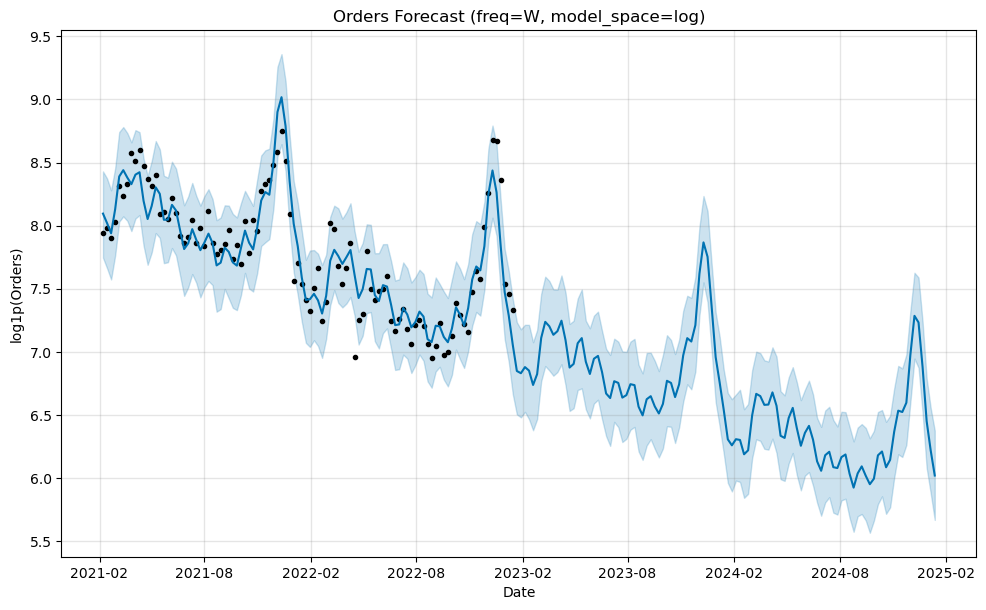

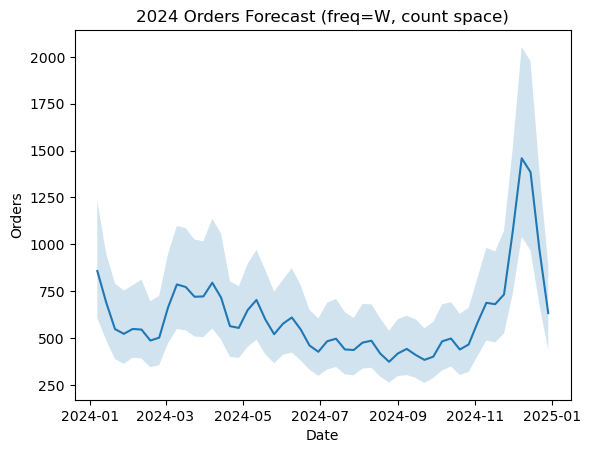

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

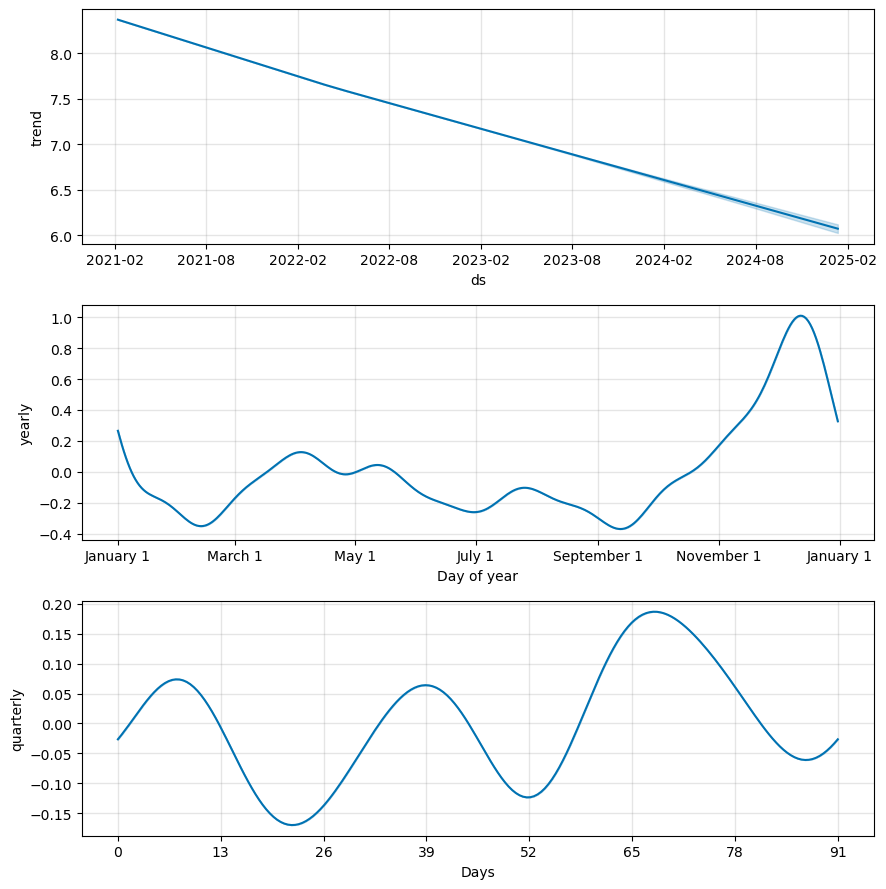

/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_10648/654023277.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sim = sim_df.resample("M").sum()
/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_10648/2407217243.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on=timestamp_col)


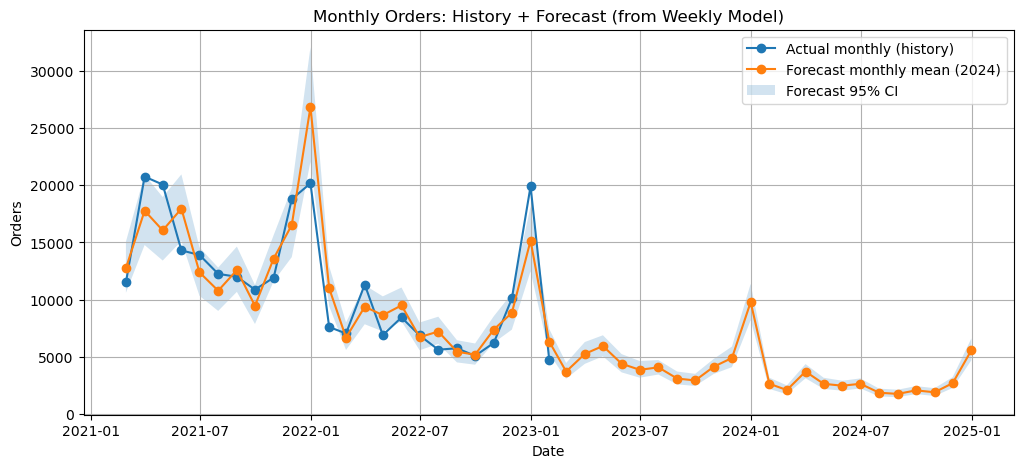

        ds    pred_mean   ci95_lower   ci95_upper
2021-02-28 12759.761418 10609.064976 15070.889565
2021-03-31 17771.332038 14777.797480 20896.191861
2021-04-30 16054.878436 13420.748384 18966.615317
2021-05-31 17948.358234 15123.762501 20942.477221
2021-06-30 12392.245854 10341.022528 14575.091762
2021-07-31 10788.823955  9023.522720 12807.898360
2021-08-31 12592.202041 10689.368007 14639.222193
2021-09-30  9475.354078  7883.138288 11289.293568
2021-10-31 13600.016428 11613.176368 15643.694166
2021-11-30 16520.402635 13720.050184 19722.571616
2021-12-31 26822.222166 22047.761504 32041.398581
2022-01-31 11007.480709  9450.310602 12928.330576
2022-02-28  6694.217072  5616.057808  8018.377644
2022-03-31  9390.294501  7862.148969 11274.252612
2022-04-30  8656.218062  7235.648847 10295.053548
2022-05-31  9507.370306  8123.353250 11069.621597
2022-06-30  6736.007416  5590.623856  8009.607184
2022-07-31  7225.710106  6145.521598  8520.118296
2022-08-31  5463.379277  4530.722636  6468.313112


In [111]:
out_w = prophet_forecast_with_scale(weekly_series, freq="W")
m = out_w["model"]

monthly_pred = weekly_to_monthly_with_ci(m, periods=104, start_date="2021-01-01",
    end_date="2024-12-31", is_log_model=True, plot=False)
plot_monthly_history_plus_forecast(df_orders, monthly_pred)
print(monthly_pred.to_string(index=False))

In [120]:
actual_monthly = (
    df_orders
    .resample("M", on="event_timestamp")
    .size()
    .reset_index(name="actual")
    .rename(columns={"event_timestamp": "ds"})
)

actual_monthly["ds"] = pd.to_datetime(actual_monthly["ds"]).dt.tz_localize(None)
eval_df = monthly_preds.merge(actual_monthly, on="ds", how="inner")

mse = np.mean((eval_df["actual"] - eval_df["pred_mean"])**2)
rmse = np.sqrt(mse)

print("Monthly MSE:", mse)
print("Monthly RMSE:", rmse)

/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_10648/2698137010.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on="event_timestamp")


Monthly MSE: 2503455.409115029
Monthly RMSE: 1582.2311490787397
